### Imports

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import random

### Defining methods to read matrix, create a csr matrix, calculating TF-IDF and L2 Norms 

In [2]:
def csr_read():
    df = pd.read_csv(
    filepath_or_buffer='train.dat', 
    header=None, 
    sep=',')
    
    nrows = len(df)
    ncols = 0 
    nnz = 0 
    for i in range(nrows):
        p = df.iloc[i,0].split()
        if len(p) % 2 != 0:
            raise ValueError("Invalid CSR matrix. Row %d contains %d numbers." % (i, len(p)))
        nnz += len(p)// 2
        for j in range(0, len(p), 2): 
            cid = int(p[j]) - 1
            if cid+1 > ncols:
                ncols = cid+1
            
    val = np.zeros(nnz, dtype=np.float)
    ind = np.zeros(nnz, dtype=np.int)
    ptr = np.zeros(nrows+1, dtype=np.long)
    n = 0 
    for i in range(nrows):
        p = df.iloc[i,0].split()
        for j in range(0, len(p), 2): 
            ind[n] = int(p[j]) - 1
            val[n] = float(p[j+1])
            n += 1
        ptr[i+1] = n 
    return csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.float)

def csr_idf(matrix):
    nrows = matrix.shape[0]
    nnz = matrix.nnz
    ind, val, ptr = matrix.indices, matrix.data, matrix.indptr

    df = defaultdict(int)
    for i in ind:
        df[i] += 1
   
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))  

    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return matrix

def csr_l2normalize(matrix):
    matrix = matrix.copy()
    nrows = matrix.shape[0]
    nnz = matrix.nnz
    ind, val, ptr = matrix.indices, matrix.data, matrix.indptr
    print(ind, val, ptr)
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  
        rsum = float(1.0/np.sqrt(rsum))
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    return matrix

### Original Dataset

In [3]:
df = pd.read_csv(
    filepath_or_buffer='train.dat', 
    header=None, 
    sep=',')
df.head()

,0
0,1237 1 1390 1 1391 5 1392 3 1393 1 1394 4 1395...
1,358 3 759 2 1070 1 3414 2 2127 1 57 2 1633 1 2...
2,3011 1 1230 1 1150 1 55 1 3414 2 1237 1 3092 1...
3,718 1 556 1 18207 1 12 2 955 1 18208 1 18209 1...
4,675 1 993 1 597 1 1230 2 53 1 15298 1 15775 1 ...


### Converting to CSR Matrix

In [4]:
csr_matrix_ = csr_read()
# print(csr_matrix_)

<ipython-input-2-459436adc940>:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.zeros(nnz, dtype=np.float)
<ipython-input-2-459436adc940>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind = np.zeros(nnz, dtyp

### Running TF IDF on CSR Matrix

In [5]:
csr_idf_ = csr_idf(csr_matrix_)
# print(csr_idf_)

### L2 Normalization

In [6]:
csr_normalized_l2 = csr_l2normalize(csr_idf_)

[ 1236  1389  1390 ... 13112 32302   912] [ 2.76747362  3.04592202  9.88160648 ... 15.91715381  7.9585769
  7.1282555 ] [      0     139     329 ... 1107699 1107832 1107980]


### Converting to Dense Matrix

In [7]:
dense_matrix = csr_normalized_l2.toarray()
dense_matrix_df = pd.DataFrame(dense_matrix)
dense_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,126345,126346,126347,126348,126349,126350,126351,126352,126353,126354
0,0.0,0.0,0.00000,0.110212,0.000000,0.003722,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.000000,0.034005,0.008336,0.0,0.0,0.057396,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.000000,0.000000,0.007764,0.0,0.0,0.004277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.000000,0.000000,0.004907,0.0,0.0,0.067576,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.02532,0.030651,0.050668,0.006210,0.0,0.0,0.034208,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### PCA Transformation

In [8]:
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn import manifold

pca = PCA(n_components=600).fit(dense_matrix)
dense_matrix_pca = pca.transform(dense_matrix)
# print(denseMatrix_pca.shape)
dense_arr = dense_matrix_pca


In [10]:
print(dense_arr.shape)

(8580, 600)


In [12]:
def calculate_centroids(matrix, clusters):
    centroids = list()
    for i in range(0,2):
        cluster = matrix[clusters[i],:]
        cluster_mean = cluster.mean(0)
        centroids.append(cluster_mean)
    centroids_array = np.asarray(centroids)
    return centroids_array

def create_clusters(matrix, centroids):
    cluster1 = []
    cluster2 = []
    similarity_matrix = matrix.dot(centroids.T)
    for i in range(similarity_matrix.shape[0]):
        row = similarity_matrix[i]
        sort_similarity_matrix = np.argsort(row)[-1]
        if sort_similarity_matrix == 0:
            cluster1.append(i)
        else:
            cluster2.append(i)
    return cluster1, cluster2

def calculate_highest_SSE(matrix, clusters):
    SSE_values = []    
    for cluster in clusters:
        elements = matrix[cluster,:]
        SSE_value = np.sum(np.square(elements - np.mean(elements)))
        SSE_values.append(SSE_value)
    return np.argsort(SSE_values)[-1]

def kmeans_clustering(matrix, Iterations):
    centroids = shuffle(matrix, random_state=7)[:2,:]
    for _ in range(Iterations):
        clusters = []
        cluster1 , cluster2 = create_clusters(matrix, centroids)
        if len(cluster1) > 1:
            clusters.append(cluster1)
        if len(cluster2) > 1:
            clusters.append(cluster2)
        centroids = calculate_centroids(matrix, clusters) 
    return cluster1, cluster2

def bisecting_kmeans(matrix, k, Iterations):
    clusters = [list(range(0, matrix.shape[0]))]
    while len(clusters) < k:
        print("len(clusters):", len(clusters), "k:", k, "Iterations:", Iterations)
        highest_sse = calculate_highest_SSE(matrix, clusters)
        print("highestSSE index", highest_sse)
        divide_cluster = clusters[highest_sse]
        cluster_1, cluster_2 = kmeans_clustering(matrix[divide_cluster,:], Iterations)
        del clusters[highest_sse]
        final_cluster_1 = []
        final_cluster_2 = []
        for idx in cluster_1:
            final_cluster_1.append(divide_cluster[idx])   
        for idx in cluster_2:
            final_cluster_2.append(divide_cluster[idx])
        clusters.append(final_cluster_1)
        clusters.append(final_cluster_2)
        
    print("len(clusters):", len(clusters), "k:", k, "Iterations:", Iterations)

    cluster_values = [0] * matrix.shape[0]

    for index, cluster in enumerate(clusters):
        for idx in cluster:
            cluster_values[idx] = index + 1
    return cluster_values

In [13]:
cluster_values =  bisecting_kmeans(dense_arr, 7, 20)
# print(cluster_values)

len(clusters): 1 k: 7 Iterations: 20
highestSSE index 0
len(clusters): 2 k: 7 Iterations: 20
highestSSE index 1
len(clusters): 3 k: 7 Iterations: 20
highestSSE index 0
len(clusters): 4 k: 7 Iterations: 20
highestSSE index 0
len(clusters): 5 k: 7 Iterations: 20
highestSSE index 1
len(clusters): 6 k: 7 Iterations: 20
highestSSE index 0
len(clusters): 7 k: 7 Iterations: 20


In [23]:
File = open("cluster_values.dat", "w")
for value in cluster_values:
    File.write(str(value) +'\n')
File.close()

len(clusters): 1 k: 3 Iterations: 20
highestSSE index 0
len(clusters): 2 k: 3 Iterations: 20
highestSSE index 1
len(clusters): 3 k: 3 Iterations: 20
len(clusters): 1 k: 5 Iterations: 20
highestSSE index 0
len(clusters): 2 k: 5 Iterations: 20
highestSSE index 1
len(clusters): 3 k: 5 Iterations: 20
highestSSE index 0
len(clusters): 4 k: 5 Iterations: 20
highestSSE index 0
len(clusters): 5 k: 5 Iterations: 20
len(clusters): 1 k: 7 Iterations: 20
highestSSE index 0
len(clusters): 2 k: 7 Iterations: 20
highestSSE index 1
len(clusters): 3 k: 7 Iterations: 20
highestSSE index 0
len(clusters): 4 k: 7 Iterations: 20
highestSSE index 0
len(clusters): 5 k: 7 Iterations: 20
highestSSE index 1
len(clusters): 6 k: 7 Iterations: 20
highestSSE index 0
len(clusters): 7 k: 7 Iterations: 20
len(clusters): 1 k: 9 Iterations: 20
highestSSE index 0
len(clusters): 2 k: 9 Iterations: 20
highestSSE index 1
len(clusters): 3 k: 9 Iterations: 20
highestSSE index 0
len(clusters): 4 k: 9 Iterations: 20
highestSSE i

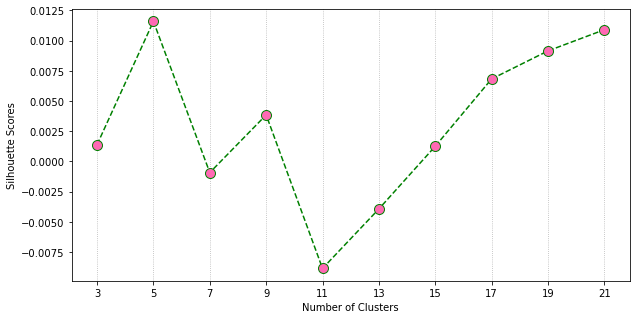

In [14]:
number_of_clusters = []
silhouette_scores = []
cluster_values = []
for k in range(3, 22, 2):
    number_of_clusters.append(k)
    cluster_values =  bisecting_kmeans(dense_arr, k, 20) 
    score = metrics.silhouette_score(dense_arr, cluster_values)
    silhouette_scores.append(score)
print(silhouette_scores)

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(number_of_clusters, silhouette_scores, 'o--g', ms=10, mfc = 'hotpink')
plt.xticks(number_of_clusters, number_of_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')
plt.grid(axis = 'x', linestyle='dotted')

plt.savefig('plot1.png')
plt.show()


In [ ]:
bisecting_kmeans(data_matrix, number_of_clusters, iterations):
clusters = list of all points
for i=0 to number_of_clusters:
    highest_sse = calculate_highest_sse(data_matrix, clusters)
    bisected_cluster = clusters[highest_sse]
    cluster1, cluster2 = kmeans_clustering(bisected_cluster, k=2, iterations)
    clusters.delete(bisected_cluster)